In [1]:
import torch as th
import math
def calculate_adaptive_adjustment(weights, seq_length):
    # 以权重的方差作为自适应调整的依据
    adjustment = th.var(weights, dim=2, keepdim=True)  # 计算沿序列长度维度的方差
    # 归一化调整到 [0, 1] 范围
    adjustment = (adjustment - adjustment.min()) / (adjustment.max() - adjustment.min())
    # 调整形状以匹配权重张量
    adjustment = adjustment.view(-1, 1, seq_length)
    return adjustment

def attention_from_qkv(qkv, num_heads):
    # 假设 qkv 形状为 (3, bs * num_heads, ch, seq_length)
    q, k, v = qkv[0], qkv[1], qkv[2]  # 分离 Q, K, V
    bs_times_num_heads, ch, seq_length = q.shape
    bs = bs_times_num_heads // num_heads
    
    scale = 1 / math.sqrt(ch)
    
    # 计算标准的注意力权重
    weight = th.einsum('bct,bcs->bts', q * scale, k * scale)
    
    # 计算自适应调整
    adaptive_adjustment = calculate_adaptive_adjustment(weight, seq_length)
    
    # 使用自适应调整来修改权重
    adaptive_weight = weight * (1 - adaptive_adjustment)
    
    # 应用 softmax 获取最终注意力概率
    adaptive_weight = th.softmax(adaptive_weight.float(), dim=-1).type(weight.dtype)
    
    return adaptive_weight




In [2]:
import torch.nn as nn
class QKVGenerator(nn.Module):
    def __init__(self, in_channels, out_channels_per_head, num_heads):
        super(QKVGenerator, self).__init__()
        # 正确设置总的输出通道数
        total_out_channels = out_channels_per_head * num_heads * 3  # Q, K, V 每部分各一份
        self.conv = nn.Conv2d(in_channels, total_out_channels, kernel_size=1)
        self.num_heads = num_heads
        self.out_channels_per_head = out_channels_per_head

    def forward(self, x):
        bs, c, h, w = x.shape
        qkv = self.conv(x)  # 应用卷积
        # 调整qkv的形状以适应后续操作
        qkv = qkv.permute(0, 2, 3, 1).view(bs, -1, 3, self.num_heads, self.out_channels_per_head).permute(2, 0, 3, 1, 4)
        qkv = qkv.reshape(3, bs * self.num_heads, self.out_channels_per_head, -1)
        return qkv


In [3]:
import torch as th
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# 假设 attention_from_qkv 已经定义
# 加载和预处理图像
image_path = 'result/newmodel670000/00000.png'
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 假设我们需要256x256的图像
    transforms.ToTensor(),
])
x = transform(image).unsqueeze(0)  # 添加batch维度

# 初始化QKV生成器
# 初始化并应用QKVGenerator
qkv_generator = QKVGenerator(in_channels=3, out_channels_per_head=64, num_heads=8)
qkv = qkv_generator(x)  # x是输入图像张量

# 计算注意力图，确保attention_from_qkv函数能处理新的qkv形状
# 注意：这里的qkv可能需要按照实际的attention_from_qkv函数的期望进行调整
attention_map = attention_from_qkv(qkv, 8)

# 可视化注意力图
plt.imshow(attention_map[0].detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('Attention Map Visualization')
plt.show()




: 

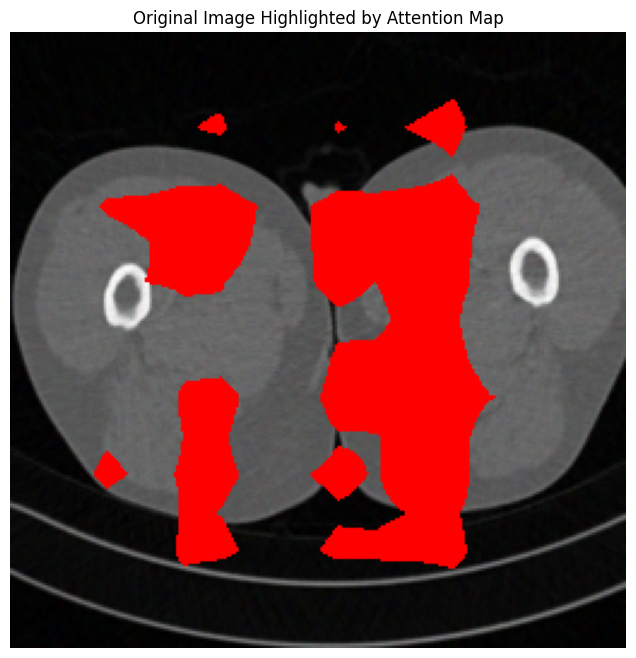

In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image, to_tensor, resize
from PIL import Image

# 加载原始图像
original_image_path = "result/6/original_image.png"
original_image = Image.open(original_image_path).convert('RGB')
original_image_tensor = to_tensor(original_image)

# 加载注意力图，并将其转换为张量
attn_map_path = 'result/6/attn_map_image.png'
selected_attn_map = Image.open(attn_map_path).convert('L')
selected_attn_map_tensor = to_tensor(selected_attn_map)

# 注意力图正规化并调整大小以匹配原始图像
normalized_attn_map = (selected_attn_map_tensor - torch.min(selected_attn_map_tensor)) / (torch.max(selected_attn_map_tensor) - torch.min(selected_attn_map_tensor))
attn_map_resized = resize(normalized_attn_map, original_image.size[::-1]).squeeze(0)  # 调整大小并去掉多余的维度

# 阈值化以提取重点区域，这里的0.9是阈值，可能需要根据实际情况调整
thresholded_attn_map = (attn_map_resized < 0.3).float()

# 创建一个全红的图像张量，与原图大小相同
red_image_tensor = torch.zeros_like(original_image_tensor)
red_image_tensor[0, :, :] = 1  # 将红色通道设置为最大值，其他通道保持为0

# 将红色点叠加到原图上
weighted_image = original_image_tensor.clone()
weighted_image[:, thresholded_attn_map.bool()] = red_image_tensor[:, thresholded_attn_map.bool()]

# 将加权后的图像转换回PIL图像以便保存和显示
weighted_image_pil = to_pil_image(weighted_image)

# 显示加权后的图像
plt.figure(figsize=(10, 8))
plt.imshow(weighted_image_pil)
plt.title('Original Image Highlighted by Attention Map')
plt.axis('off')
plt.show()

# 保存加权后的图像到本地
weighted_image_pil.save('result/6/weighted_image_with_red_dots.png')


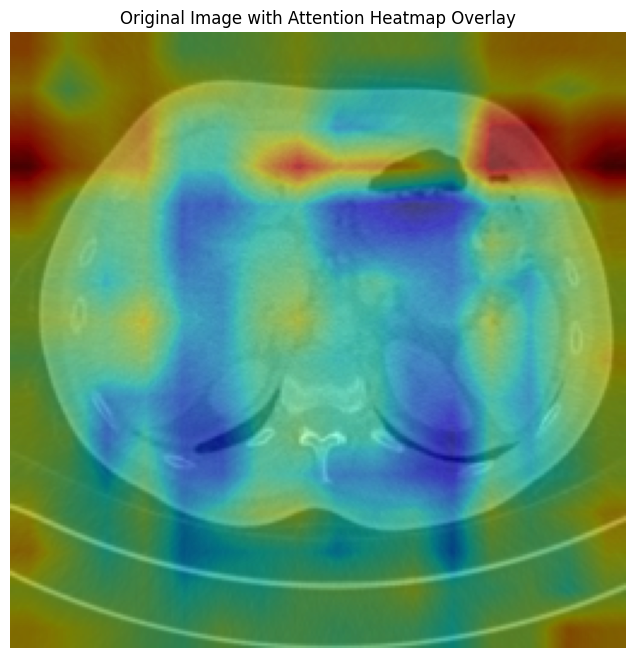

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.transforms.functional import to_pil_image, to_tensor, resize
import torch

# 加载原始图像和注意力图
original_image_path = "result/2/original_image.png"
original_image = Image.open(original_image_path).convert('RGB')
original_image_tensor = to_tensor(original_image)

attn_map_path = 'result/3/attn_map_image.png'
selected_attn_map = Image.open(attn_map_path).convert('L')
attn_map_tensor = to_tensor(selected_attn_map)

# 注意力图正规化并调整大小
normalized_attn_map = (attn_map_tensor - torch.min(attn_map_tensor)) / (torch.max(attn_map_tensor) - torch.min(attn_map_tensor))
attn_map_resized = resize(normalized_attn_map, original_image.size[::-1])

# 显示原始图像与热图叠加效果
plt.figure(figsize=(10, 8))
plt.imshow(original_image)
plt.imshow(attn_map_resized.squeeze(0), cmap='jet', alpha=0.5)  # 使用'jet'色图与alpha透明度
plt.axis('off')
plt.title('Original Image with Attention Heatmap Overlay')
plt.show()


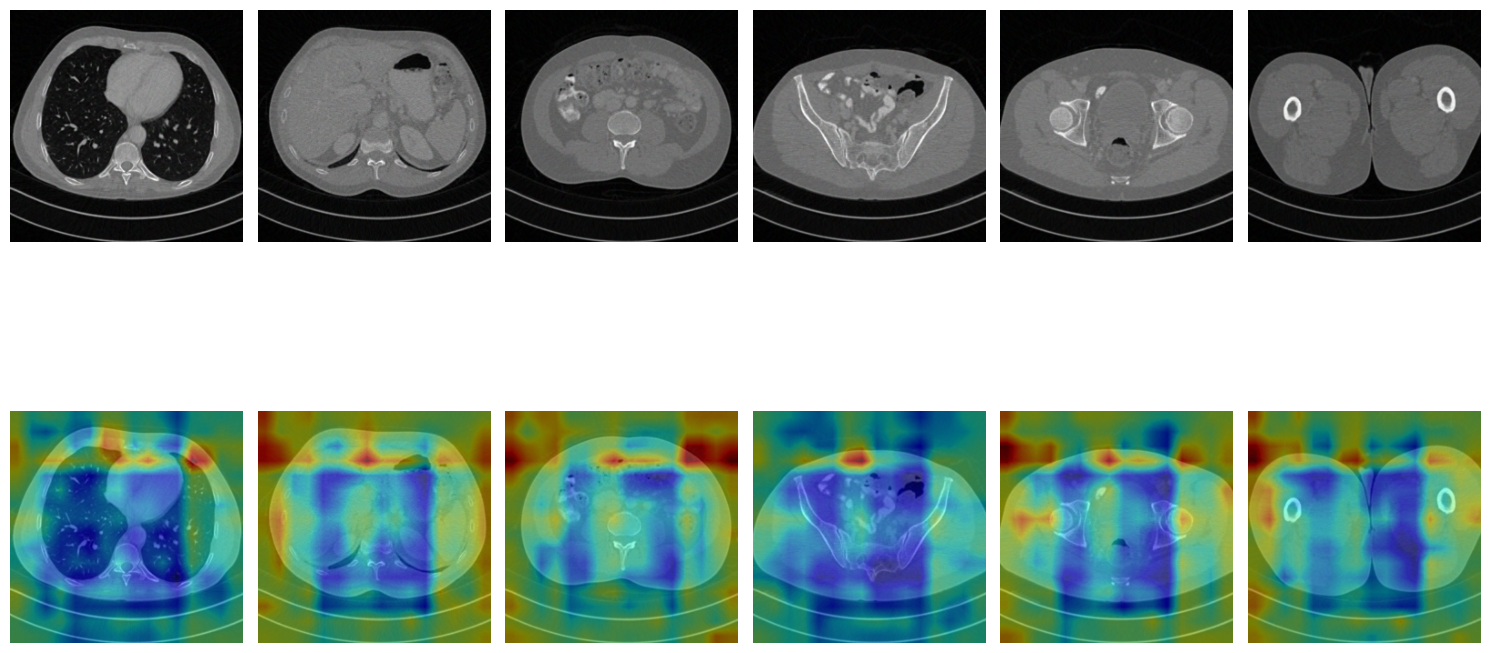

In [54]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import functional as TF
import torch

# 设定要加载图像的文件夹
folders = range(1, 7)
base_path = "result"

# 设置图像展示的大小
plt.figure(figsize=(15, 10))

for i, folder in enumerate(folders):
    # 加载原始图像
    original_image_path = f"{base_path}/{folder}/original_image.png"
    original_image = Image.open(original_image_path).convert('RGB')

    # 加载注意力图，并将其转换为张量
    attn_map_path = f"{base_path}/{folder}/attn_map_image.png"
    selected_attn_map = Image.open(attn_map_path).convert('L')
    attn_map_tensor = TF.to_tensor(selected_attn_map)

    # 注意力图正规化并调整大小以匹配原始图像
    normalized_attn_map = (attn_map_tensor - torch.min(attn_map_tensor)) / (torch.max(attn_map_tensor) - torch.min(attn_map_tensor))
    attn_map_resized = TF.resize(normalized_attn_map, original_image.size[::-1])

    # 第一排显示原始图像
    plt.subplot(2, len(folders), i+1)
    plt.imshow(original_image)
    plt.axis('off')

    # 第二排显示原始图像与热力图叠加效果
    plt.subplot(2, len(folders), len(folders) + i+1)
    plt.imshow(original_image)
    plt.imshow(attn_map_resized.squeeze(0), cmap='jet', alpha=0.5)  # 使用'jet'色图与alpha透明度
    plt.axis('off')

plt.tight_layout()
plt.show()


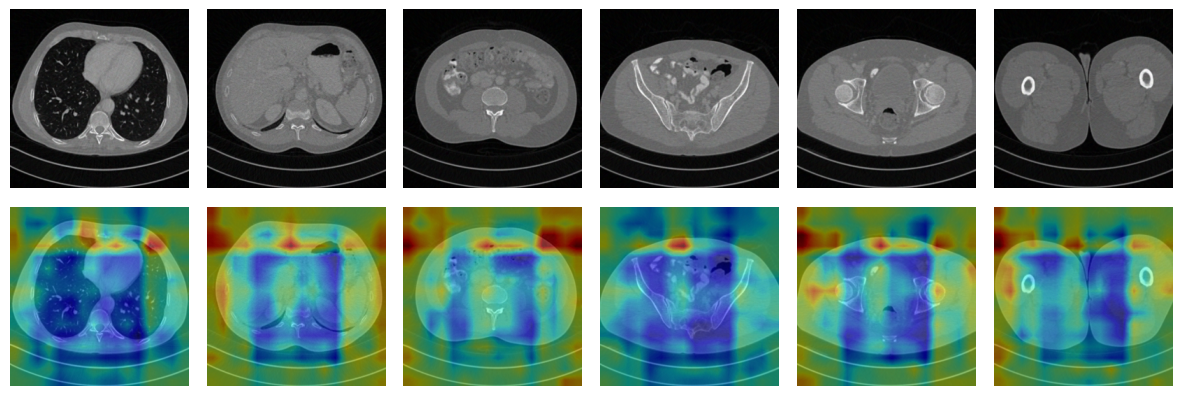

In [66]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import functional as TF
import torch

# 设定要加载图像的文件夹
folders = range(1, 7)
base_path = "result"

# 设置图像展示的大小
fig, axs = plt.subplots(2, len(folders), figsize=(15, 6))

for i, folder in enumerate(folders):
    # 加载原始图像
    original_image_path = f"{base_path}/{folder}/original_image.png"
    original_image = Image.open(original_image_path).convert('RGB')

    # 加载注意力图，并将其转换为张量
    attn_map_path = f"{base_path}/{folder}/attn_map_image.png"
    selected_attn_map = Image.open(attn_map_path).convert('L')
    attn_map_tensor = TF.to_tensor(selected_attn_map)

    # 注意力图正规化并调整大小以匹配原始图像
    normalized_attn_map = (attn_map_tensor - torch.min(attn_map_tensor)) / (torch.max(attn_map_tensor) - torch.min(attn_map_tensor))
    attn_map_resized = TF.resize(normalized_attn_map, original_image.size[::-1])

    # 第一排显示原始图像
    ax = axs[0, i]
    ax.imshow(original_image)
    ax.axis('off')

    # 第二排显示原始图像与热力图叠加效果
    ax = axs[1, i]
    ax.imshow(original_image)
    ax.imshow(attn_map_resized.squeeze(0), cmap='jet', alpha=0.5)  # 使用'jet'色图与alpha透明度
    ax.axis('off')

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.1, hspace=-0.25)  # 调整水平和垂直间距

plt.show()


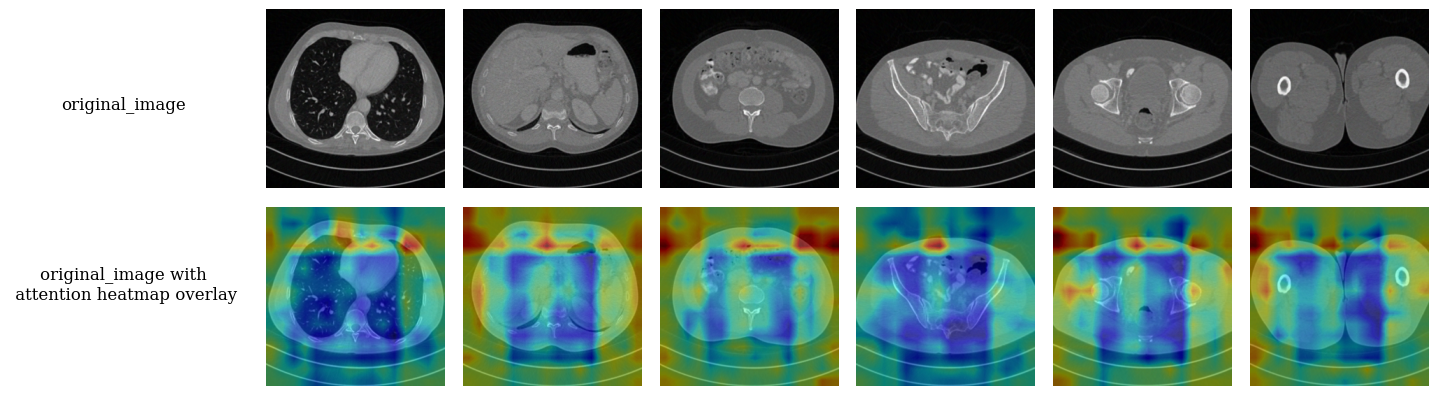

In [80]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import functional as TF
import torch

plt.rcParams['font.family'] = 'serif'

plt.rcParams['font.size'] = 12

# 设定要加载图像的文件夹
folders = range(1, 7)
base_path = "result"

# 设置图像展示的大小
fig, axs = plt.subplots(2, len(folders), figsize=(15, 6))

# 描述性文本
descriptions = ['original_image', 'original_image with\n attention heatmap overlay']

for i, folder in enumerate(folders, start=1):  # start=1 为了留出描述的空间
    # 加载原始图像
    original_image_path = f"{base_path}/{folder}/original_image.png"
    original_image = Image.open(original_image_path).convert('RGB')

    # 加载注意力图，并将其转换为张量
    attn_map_path = f"{base_path}/{folder}/attn_map_image.png"
    selected_attn_map = Image.open(attn_map_path).convert('L')
    attn_map_tensor = TF.to_tensor(selected_attn_map)

    # 注意力图正规化并调整大小以匹配原始图像
    normalized_attn_map = (attn_map_tensor - torch.min(attn_map_tensor)) / (torch.max(attn_map_tensor) - torch.min(attn_map_tensor))
    attn_map_resized = TF.resize(normalized_attn_map, original_image.size[::-1])

    # 显示原始图像
    ax = axs[0, i-1]  # 更新索引，留出描述空间
    ax.imshow(original_image)
    ax.axis('off')

    # 显示原始图像与热力图叠加效果
    ax = axs[1, i-1]  # 更新索引
    ax.imshow(original_image)
    ax.imshow(attn_map_resized.squeeze(0), cmap='jet', alpha=0.5)  # 使用'jet'色图与alpha透明度
    ax.axis('off')

# 在预留的空间添加描述性文本
fig.text(0.03, 0.65, descriptions[0], ha='center', va='center', fontsize=12)
fig.text(0.03, 0.35, descriptions[1], ha='center', va='center', fontsize=12)

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.1, hspace=-0.25)  # 调整水平和垂直间距

plt.show()


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

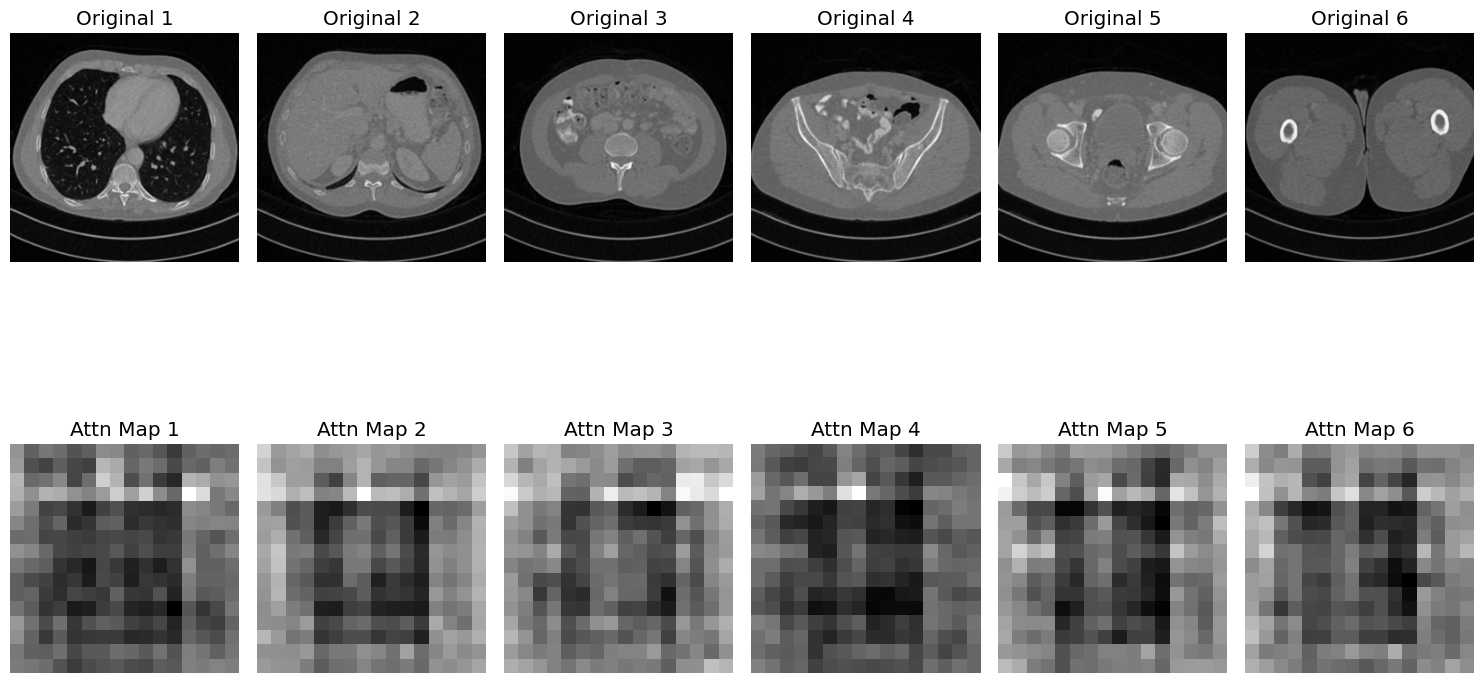

In [74]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# 设定文件夹路径
folder_paths = [f'result/{i}' for i in range(1, 7)]

# 设定图像尺寸
plt.figure(figsize=(15, 10))

# 遍历每个文件夹，加载并展示原始图像和注意力图
for i, folder_path in enumerate(folder_paths):
    # 定位原始图像和注意力图的路径
    original_image_path = os.path.join(folder_path, "original_image.png")  # 假设原始图像命名为 original_image.png
    attn_map_path = os.path.join(folder_path, "attn_map_image.png")  # 假设注意力图命名为 attn_map_image.png

    # 加载图像
    original_image = Image.open(original_image_path)
    attn_map = Image.open(attn_map_path)

    # 展示原始图像
    plt.subplot(2, len(folder_paths), i + 1)
    plt.imshow(original_image)
    plt.title(f'Original {i+1}')
    plt.axis('off')

    # 展示注意力图
    plt.subplot(2, len(folder_paths), len(folder_paths) + i + 1)
    plt.imshow(attn_map,cmap='gray')
    plt.title(f'Attn Map {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()
